## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from scipy.spatial.distance import cdist
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import cupy as cp
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

from scripts.helpers import *
from scripts.glamos_preprocess import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
seed_all(SEED)

In [3]:
# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

## Get data:

In [ ]:
# Switch to oggm datapulling notebook:
df_pmb_topo = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv')
print('Number of winter and annual samples:', len(df_pmb_topo))
print('Number of annual samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'winter']))
df_pmb_topo.head(2)

# Specify the short names of the climate variables available in the dataset
vois_climate = ['t2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str']
# voi_topographical = ['aspect', 'slope', 'dis_from_border', 'topo']
voi_topographical = ['aspect', 'slope']

# take only annual and not winter MB
data = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv')
data = data[data.PERIOD == 'annual']

# change mm w.e. to m w.e.
data['POINT_BALANCE'] = data['POINT_BALANCE'] / 1000

# Provide the column name for the column that has the RGI IDs for each of the stakes
dataset = mbm.Dataset(data=data,
                      region_name='CH',
                      data_path=path_PMB_GLAMOS_csv)

# Add climate data:
# Specify the files of the climate data, that will be matched with the coordinates of the stake data
era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'

# Match the climate features, from the ERA5Land netCDF file, for each of the stake measurement dataset
dataset.get_climate_features(climate_data=era5_climate_data,
                             geopotential_data=geopotential_data,
                             change_units=True)
dataset.data.head(2)

In [ ]:
# Plot temperature and precipitation for all stakes:
fig = plt.figure(figsize=(15, 15))
df = dataset.data
year = 2006

for i, var in enumerate(vois_climate):
    temp = df[df.YEAR == year][[col for col in df.columns if var in col]]
    mean = temp.mean().values
    std = temp.std().values
    ax = plt.subplot(4, 2, i + 1)
    ax.fill_between(
        temp.columns,
        mean - std,
        mean + std,
        color="orange",
        alpha=0.3,
    )
    # put x axis at 45 degrees
    ax.set_xticklabels(temp.columns, rotation=90)
    ax.plot(temp.columns, mean, label='Mean Annual Point SMB', linestyle="--")
    ax.set_title(vois_climate_long_name[var])
    ax.set_ylabel(vois_units[var])

plt.suptitle('Over all stakes for year ' + str(year))
plt.tight_layout()

### Monthly format:

In [ ]:
# For each record, convert to a monthly time resolution
dataset.convert_to_monthly(vois_climate=vois_climate,
                           vois_topographical=voi_topographical)
dataset.data.head(2)

### Splits:

In [ ]:
df = dataset.data
# Create a new DataLoader object with the monthly stake data measurements.
dataloader = mbm.DataLoader(data=df, random_seed=SEED)

# Create a training and testing iterators. The parameters are optional. The default value of test_size is 0.3.
train_itr, test_itr = dataloader.set_train_test_split(test_size=0.3,
                                                      shuffle=True)

# Get all indices of the training and testing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, test_indices = list(train_itr), list(test_itr)

# Get the features and targets of the training data for the indices as defined above, that will be used during the cross validation.
df_X_train = df.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get test set
df_X_test = df.iloc[test_indices]
y_test = df_X_test['POINT_BALANCE'].values

# Create the cross validation splits based on the training dataset. The default value for the number of splits is 5.
splits = dataloader.get_cv_split(n_splits=5)

In [ ]:
# For each of the XGBoost parameter, define the grid range
parameters = {
    'max_depth': [
        3,
        4,
        5,
        6,
    ],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 1]
}

# objective = 'reg:absoluteerror' #"reg:squarederror"
param_init = {}
param_init["gpu_id"] = 0
param_init["tree_method"] = "gpu_hist"
# param_init["objective"] = objective
param_init["random_state"] = SEED

# Create a CustomXGBoostRegressor instance
custom_xgboost = mbm.models.CustomXGBoostRegressor(random_seed=SEED,
                                                   **param_init)
custom_xgboost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rsv = RandomizedSearchCV(custom_xgboost,
                         parameters,
                         n_iter=5,
                         cv=splits,
                         random_state=SEED)
# Separate the features from the metadata provided in the dataset
# features, metadata = custom_xgboost._create_features_metadata(df_X_train)
rsv.fit(df_X_train, y_train)

In [ ]:
print("Best parameters:\n", rsv.best_params_)
print("Best score:\n", rsv.best_score_)

## Test on Silvretta:

In [4]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)

rgi_silvretta = rgi_df.loc['silvretta']['rgi_id.v6']

data = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv')
# data = data[(data.PERIOD == 'annual') & (data.RGIId == rgi_silvretta)]
data = data[data.RGIId == rgi_silvretta]

print('Number of winter and annual samples:', len(data))
print('Number of annual samples:', len(data[data.PERIOD == 'annual']))
print('Number of winter samples:', len(data[data.PERIOD == 'winter']))

# change mm w.e. to m w.e.
data['POINT_BALANCE'] = data['POINT_BALANCE'] / 1000
data.head(2)

Number of winter and annual samples: 1611
Number of annual samples: 1367
Number of winter samples: 244


,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId,aspect,slope,dis_from_border,topo
7941,1961,BU,silvretta,19600927,19610830,46.852703,10.076482,2807.186711,0.739,annual,RGI60-11.00804,5.403523,0.121847,511.132080,2737.0
7942,1961,10,silvretta,19600831,19610928,46.852529,10.065569,2725.198255,0.620,annual,RGI60-11.00804,6.137308,0.379743,76.026314,2663.0


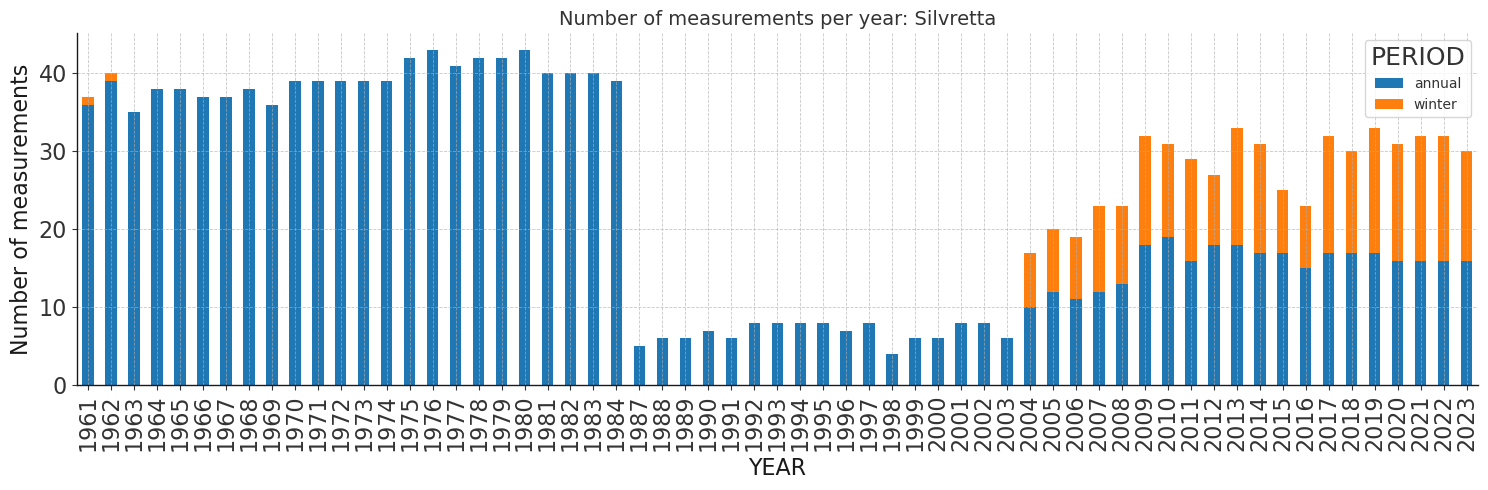

In [5]:
# Plot number of measurements per year
# Number of measurements per glacier per year:
num_gl_yr = data.groupby(['YEAR', 'PERIOD']).size().unstack().reset_index()

# Plot one glacier per column:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
num_gl_yr.plot(x='YEAR', kind='bar', stacked=True, ax=ax, title='Silvretta')
ax.set_ylabel('Number of measurements')
ax.set_title('Number of measurements per year: Silvretta', fontsize=14)
plt.tight_layout()

In [6]:
# Specify the short names of the climate variables available in the dataset
vois_climate = ['t2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str']
# voi_topographical = ['aspect', 'slope', 'dis_from_border', 'topo']
voi_topographical = ['aspect', 'slope']

# Provide the column name for the column that has the RGI IDs for each of the stakes
dataset = mbm.Dataset(data=data,
                      region_name='CH',
                      data_path=path_PMB_GLAMOS_csv)

# Add climate data:
# Specify the files of the climate data, that will be matched with the coordinates of the stake data
era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'

# Match the climate features, from the ERA5Land netCDF file, for each of the stake measurement dataset
dataset.get_climate_features(climate_data=era5_climate_data,
                             geopotential_data=geopotential_data,
                             change_units=True)
dataset.data.head(2)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE
0,1961,BU,silvretta,19600927,19610830,46.852703,10.076482,2807.186711,0.739,annual,...,0.00538,0.002226,0.003634,0.005938,0.003392,0.005095,0.004692,0.001377,2255.441697,-551.745014
1,1961,10,silvretta,19600831,19610928,46.852529,10.065569,2725.198255,0.620,annual,...,0.00538,0.002226,0.003634,0.005938,0.003392,0.005095,0.004692,0.001377,2255.441697,-469.756558


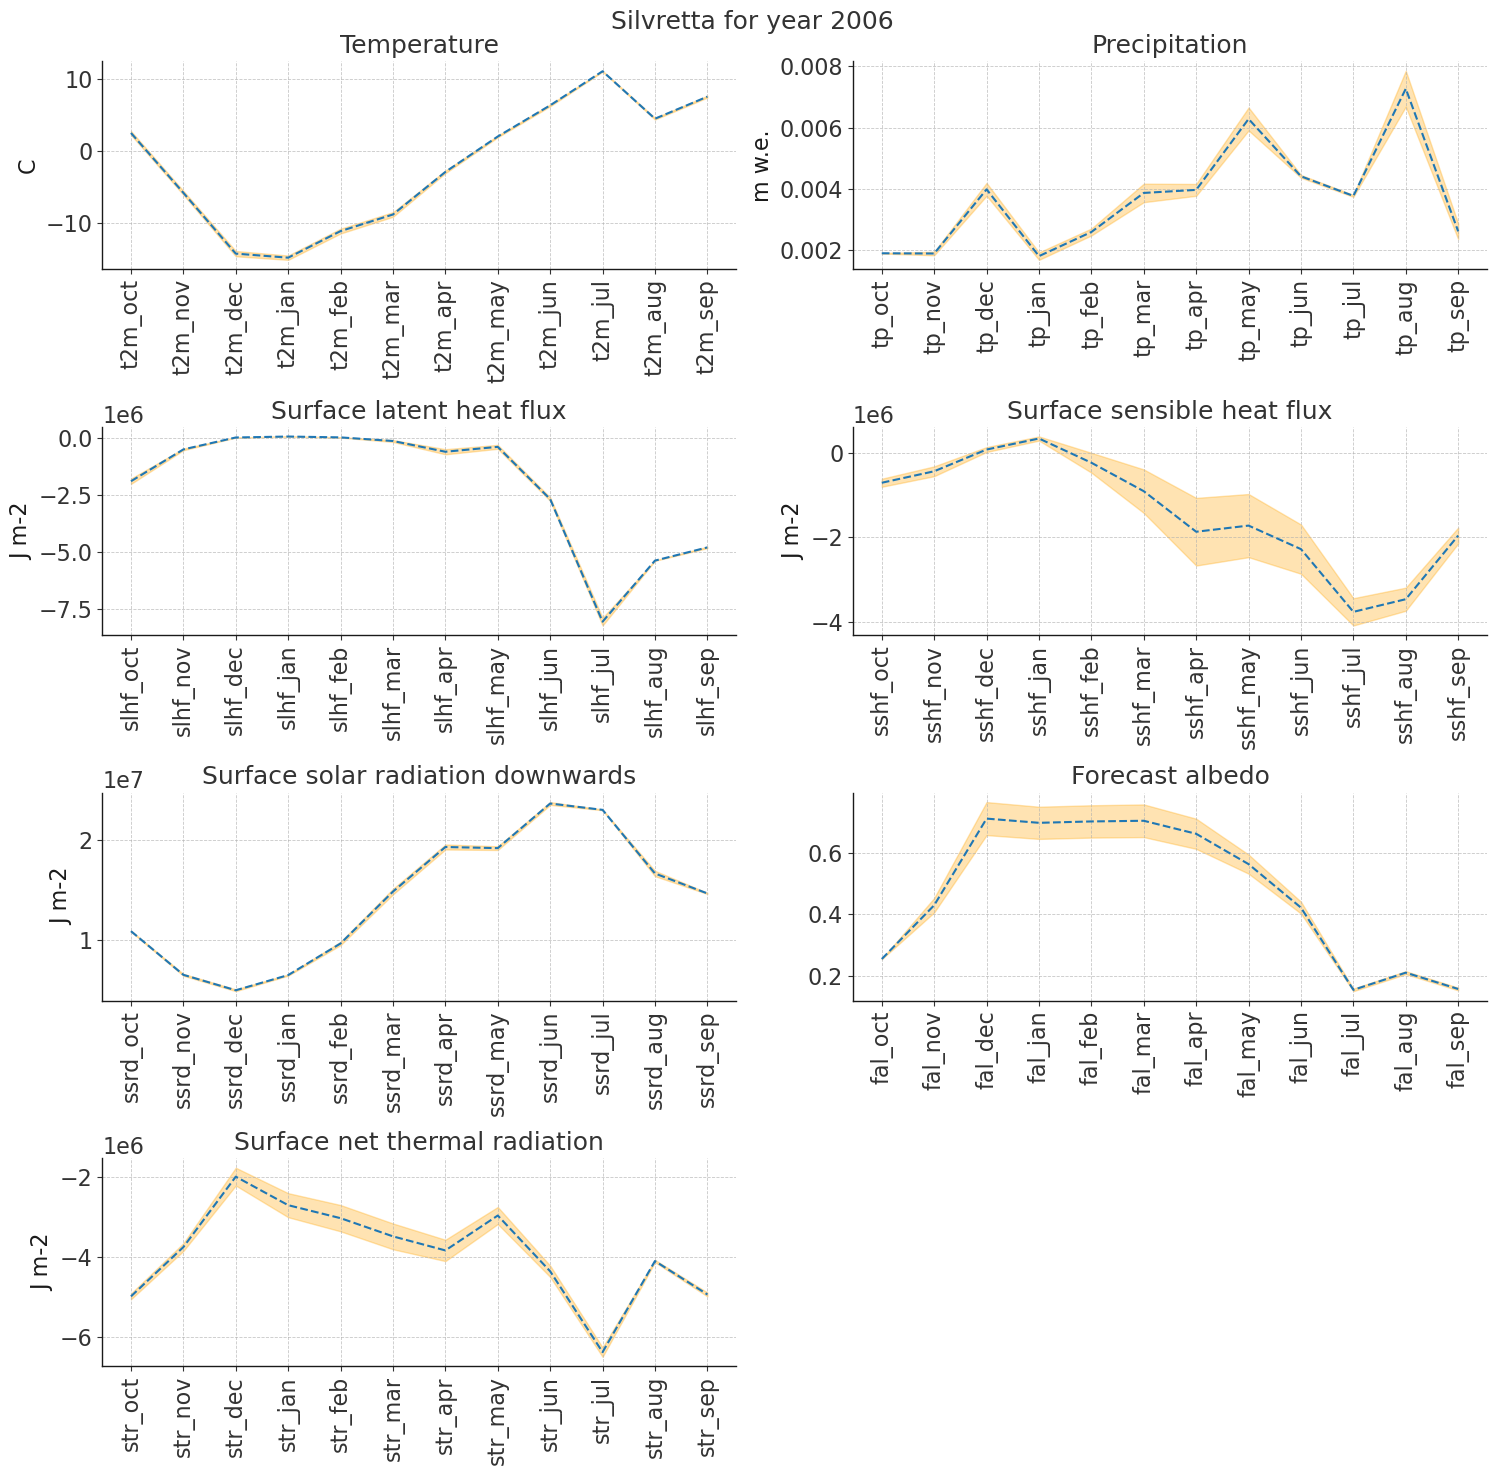

In [7]:
# Plot temperature and precipitation for all stakes:
fig = plt.figure(figsize=(15, 15))
df = dataset.data
year = 2006

for i, var in enumerate(vois_climate):
    temp = df[df.YEAR == year][[col for col in df.columns if var in col]]
    mean = temp.mean().values
    std = temp.std().values
    ax = plt.subplot(4, 2, i + 1)
    ax.fill_between(
        temp.columns,
        mean - std,
        mean + std,
        color="orange",
        alpha=0.3,
    )
    # put x axis at 45 degrees
    ax.set_xticklabels(temp.columns, rotation=90)
    ax.plot(temp.columns, mean, label='Mean Annual Point SMB', linestyle="--")
    ax.set_title(vois_climate_long_name[var])
    ax.set_ylabel(vois_units[var])

plt.suptitle('Silvretta for year ' + str(year))
plt.tight_layout()

### Convert to monthly and splits:

In [8]:
# For each record, convert to a monthly time resolution
dataset.convert_to_monthly(vois_climate=vois_climate,
                           vois_topographical=voi_topographical)
dataset.data.head(2)

,MONTHS,ID,RGIId,POINT_ID,YEAR,N_MONTHS,PERIOD,POINT_LON,POINT_LAT,POINT_BALANCE,...,ELEVATION_DIFFERENCE,aspect,slope,t2m,tp,slhf,sshf,ssrd,fal,str
0,oct,0,RGI60-11.00804,BU,1961,10,annual,10.076482,46.852703,0.739,...,-551.745014,5.403523,0.121847,-2.679355,0.005248,-714305.115896,-296025.401584,1.001958e+07,0.644413,-2.892480e+06
1,nov,0,RGI60-11.00804,BU,1961,10,annual,10.076482,46.852703,0.739,...,-551.745014,5.403523,0.121847,-6.812539,0.002970,-107968.075809,54141.234157,6.573773e+06,0.722370,-2.357960e+06


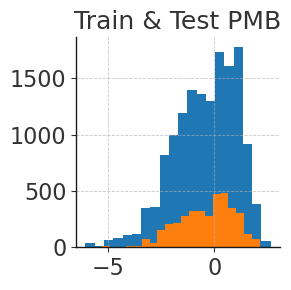

In [9]:
# Create a new DataLoader object with the monthly stake data measurements.
dataloader = mbm.DataLoader(data=dataset.data, random_seed=SEED)

# Create a training and testing iterators. The parameters are optional. The default value of test_size is 0.3.
train_itr, test_itr = dataloader.set_train_test_split(test_size=0.2,
                                                      shuffle=True)

# Get all indices of the training and testing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, test_indices = list(train_itr), list(test_itr)

# Get the features and targets of the training data for the indices as defined above, that will be used during the cross validation.
df_X_train = dataset.data.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get test set
df_X_test = dataset.data.iloc[test_indices]
y_test = df_X_test['POINT_BALANCE'].values

# Look at distribution of train and test
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.hist(y_train, bins=20)
ax.set_title('Train & Test PMB')
ax.hist(y_test, bins=20)
plt.tight_layout()

In [17]:
test_meas_id = df_X_test['ID'].unique()

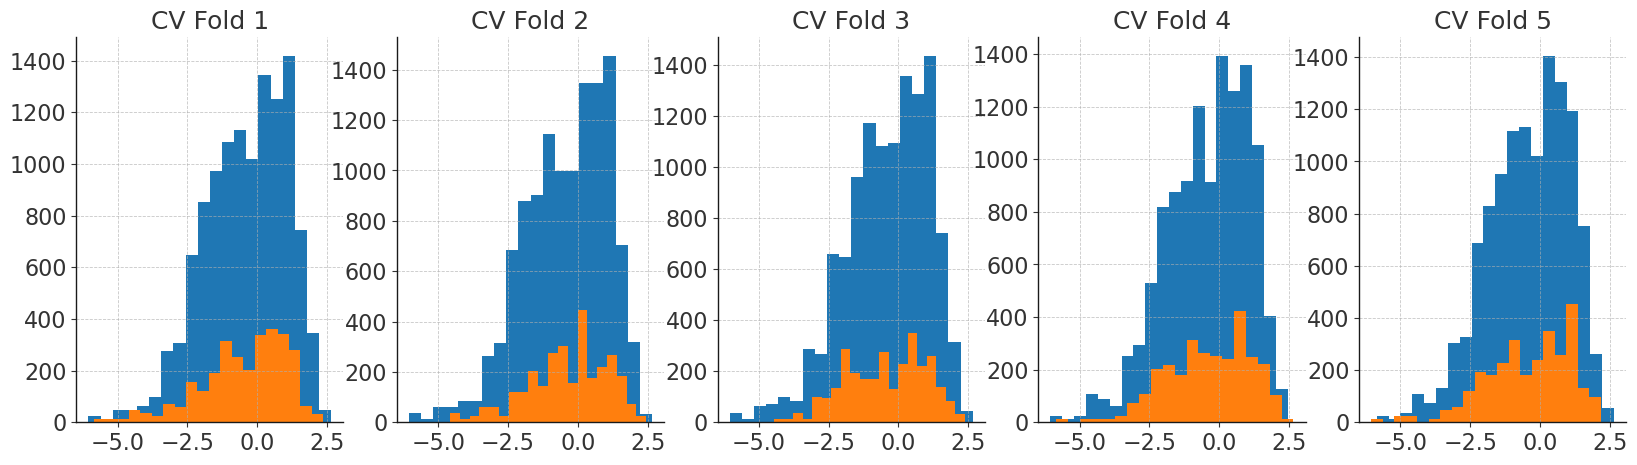

In [19]:
# Create the cross validation splits based on the training dataset. The default value for the number of splits is 5.
# splits = dataloader.get_cv_split(n_splits=5, type_fold = 'group-stake')
splits = dataloader.get_cv_split(n_splits=5, type_fold='group-meas-id')

# Visualise the cross validation splits
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i, (train_idx, val_idx) in enumerate(splits):
    # Check that there is no overlap between the training, val and test IDs
    train_meas_id = df_X_train.iloc[train_idx]['ID'].unique()
    val_meas_id = df_X_train.iloc[val_idx]['ID'].unique()
    assert len(set(train_meas_id).intersection(set(val_meas_id))) == 0
    assert(len(set(train_meas_id).intersection(set(test_meas_id))) == 0)
    assert(len(set(val_meas_id).intersection(set(test_meas_id))) == 0)
    ax[i].hist(y_train[train_idx], bins=20)
    ax[i].hist(y_train[val_idx], bins=20)
    ax[i].set_title('CV Fold ' + str(i + 1))

### Grid search:
Feature columns:
- 'ALTITUDE_CLIMATE'
- 'ELEVATION_DIFFERENCE'
- 'POINT_BALANCE'
- 'POINT_LAT'
- 'POINT_LON'
- 'YEAR'
- 'aspect'
- 'dis_from_border'
- 'fal'
- 'slhf'
- 'slope'
- 'sshf'
- 'ssrd'
- 'str'
- 't2m'
- 'topo'
- 'tp'

In [11]:
%%time
# Grid search
# For each of the XGBoost parameter, define the grid range
parameters = {
    'max_depth': [
        3,
        4,
        5,
        6,
    ],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 1]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = SEED

# Create a CustomXGBoostRegressor instance
custom_xgboost = mbm.models.CustomXGBoostRegressor(**param_init)
custom_xgboost.randomsearch(
    parameters=parameters,
    n_iter=20,
    splits=splits,
    features=df_X_train,
    targets=y_train,
    num_jobs=-1,
    random_seed=SEED,
)

best_params = params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters:
 {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 1}
Best score:
 -0.007001280576458274
CPU times: user 40.1 s, sys: 807 ms, total: 40.9 s
Wall time: 50 s


### Predict with best model:

In [13]:
# Set to CPU for predictions:
xgb = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = xgb._create_features_metadata(df_X_test)
y_pred = xgb.predict(features_test)

# Make predictions aggr to meas ID:
y_pred_agg = xgb.aggrPredict(metadata_test, features_test)

# Calculate scores
score = xgb.score(df_X_test, y_test)  # negative
mse, rmse, mae = xgb.evalMetrics(metadata_test, y_pred, y_test)

# Aggregate predictions to annual or winter:
df_pred = df_X_test.copy()
df_pred['target'] = y_test
grouped_ids = df_pred.groupby('ID').agg({'target': 'mean'})
grouped_ids['pred'] = y_pred_agg
grouped_ids['PERIOD'] = df_X_test.groupby('ID')['PERIOD'].first()

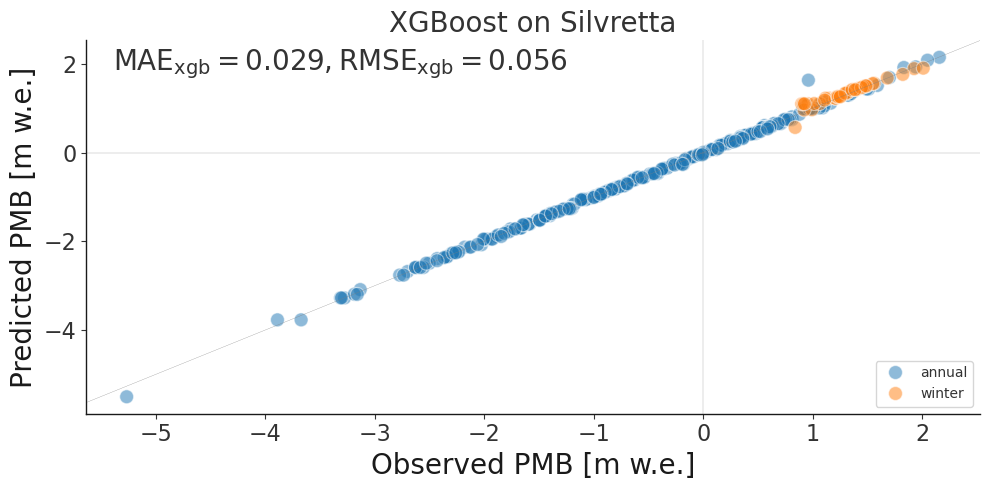

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

legend_xgb = "\n".join(
    (r"$\mathrm{MAE_{xgb}}=%.3f, \mathrm{RMSE_{xgb}}=%.3f$ " % (
        mae,
        rmse,
    ), ))

marker_xgb = 'o'
colors = get_cmap_hex(cm.batlow, 2)
color_xgb = colors[0]
sns.scatterplot(
    grouped_ids,
    x="target",
    y="pred",
    # color=color_xgb,
    hue = 'PERIOD',
    ax=ax,
    alpha=0.5,
    marker=marker_xgb)

ax.set_ylabel('Predicted PMB [m w.e.]', fontsize=20)
ax.set_xlabel('Observed PMB [m w.e.]', fontsize=20)

ax.text(0.03,
        0.98,
        legend_xgb,
        transform=ax.transAxes,
        verticalalignment="top",
        fontsize=20)
ax.legend()
# ax.legend([], [], frameon=False)
# diagonal line
pt = (0, 0)
ax.axline(pt, slope=1, color="grey", linestyle="-", linewidth=0.2)
ax.axvline(0, color="grey", linestyle="-", linewidth=0.2)
ax.axhline(0, color="grey", linestyle="-", linewidth=0.2)
ax.grid()
ax.set_title('XGBoost on Silvretta', fontsize=20)
plt.tight_layout()

### Use custom model:

In [ ]:
# Fit custom model with custom parameters:
# param_init = {}
# param_init['device'] = 'cuda:0'
# param_init['tree_method'] = 'hist'
# param_init["random_state"] = SEED

# custom_params = {
#     'n_estimators': 200,
#     'max_depth': 6,
#     'learning_rate': 0.1,
#     'gamma': 0
# }

# params_xgb = {**param_init, **params}

# # Create a CustomXGBoostRegressor instance
# xgb = mbm.models.CustomXGBoostRegressor(**params_xgb)

# Fit the model on training
# best_estimator.fit(df_X_train, y_train)
